In [1]:
import numpy as np
import pyfits
import math
from math import log10
import matplotlib.pyplot as plt
import scipy
from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d
from matplotlib import rc
import pickle
import os
import astropy as ap
from astropy.cosmology import WMAP7
from scipy import interpolate
import corner
import matplotlib.patheffects as patheffects
from matplotlib import rcParams
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib import rc
from matplotlib import colors
from __future__ import unicode_literals
# rcParams["font.size"] = 16
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"

rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'

# rcParams['font.family'] = 'serif'
# rcParams['font.serif'] = 'Ubuntu'
# rcParams['font.monospace'] = 'Ubuntu Mono'
rcParams['font.size'] = 22
rcParams['axes.labelsize'] = 22
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.titlesize'] = 17
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 16
rcParams['figure.titlesize'] = 1

os.chdir('/Users/nitya/Work/Data/Project1/measurements')



In [2]:
os.chdir('/Users/nitya/Work/Data/Project1/measurements')
print(os.getcwd())
file2 = open(r'tracer_bin_opt_inf.pkl', 'rb')
d = pickle.load(file2, encoding = 'Latin1')
file2.close()
#What's up with 445?

print(np.shape(d))

file3 = open(r'tracer_bins_nsaid.pkl', 'rb')
b = pickle.load(file3, encoding = 'Latin1')
file3.close()

b.dtype.names

print(len(b))


# indz = np.where(d[:,0]!=445)[0]
# d = d[indz]
# print np.shape(d)
bins = [np.int(d[:,0][i]) for i in range(len(d[:,0]))]
res = [bins[i]- np.int(b[:,0][i]) for i in range(len(bins))]

binlist = b[:,1]
#print(binlist[0:5])


/Users/nitya/Work/Data/Project1/measurements
(467, 3)
467


In [3]:
afile = open(r'interpolated_data_radec.pkl', 'rb')
d = pickle.load(afile, encoding = 'latin1')
afile.close()
print(d.dtype.names)
print(len(d))

green_valley = len(d['opt'][(d['opt']>2.5) & (d['opt']<4.5)])

outliers = len(d['opt'][(d['opt']>2.5) & (d['opt']<4.5) & (d['inf']>1.5)])
print(green_valley, outliers, outliers*100/green_valley)

('nsaid', 'z', 'ra', 'dec', 'opt', 'inf', 'mass', 'magsfr', 'magphys', 'uv', 'uvssfr', 'env')
61046
26267 3734 14.21555564015685


So ~ 14.2% of the green valley are the outliers;

In [4]:
#Reading the Magphys spectra..;
os.chdir('/Users/nitya/Work/Data/Project1/Magphys')


print(os.getcwd())
file1 = [str(bins[i]) + '.0' + '.fit' for i in range(len(bins))]

lines = np.asarray([open(file1[i]).readlines() for i in range(len(bins))])
print(np.shape(lines))
ble = np.vectorize(np.float)

b = np.asarray([ble(lines[i][2].split()) for i in range(len(bins))])

w1jy = b[:,7]
lambda_eff = 3.3526
print(w1jy[0:10])

w1lum = [w1jy[i]*3.0*(10.0**14.0)/(0.6189) for i in range(len(bins))]

print(w1lum[0:10])
c = np.asarray([ble(lines[i][10].split()) for i in range(len(bins))])
#3: TauV 2: mu 4: SSFR 5: "Mass" 6: Ldust in solar luminosities
ssfr = c[:,4]
log_ssfr = np.asarray([log10(c[:,4][i]) for i in range(len(bins))])
mass =c[:,5]

w1_mtol = np.asarray([mass[i]/w1lum[i] for i in range(len(bins))])

file2 = [str(bins[i]) + '.0' + '.sed' for i in range(len(bins))]
lines2 = np.asarray([open(file2[i]).readlines()[10:] for i in range(len(bins))])
print(np.shape(lines2))
sed = np.asarray([[ble(lines2[i][j].split()) for j in range(12816)] for i in range(len(bins))])

/Users/nitya/Work/Data/Project1/Magphys
(467, 681)
[3.689e-17 3.576e-17 3.212e-17 3.834e-17 4.045e-17 2.592e-17 1.673e-17
 2.769e-17 2.575e-17 1.461e-16]
[0.01788172564226854, 0.01733397964129908, 0.015569558894813379, 0.018584585555016967, 0.019607367910809505, 0.012564226854095977, 0.008109549200193892, 0.013422200678623365, 0.012481822588463403, 0.07081919534658265]
(467, 12816)


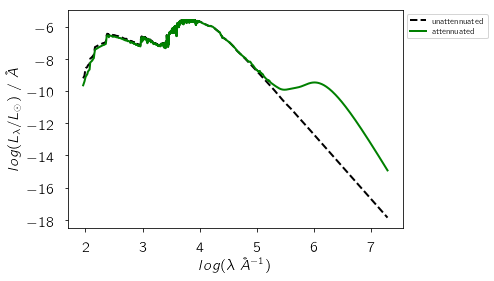

In [5]:
wav = sed[0][:,0]
#unattennuated
us = sed[0][:,2]
#attennuated
us1 = sed[0][:,1]

plt.plot(wav,us, color = 'k',lw = 2.0,linestyle = '--', label = 'unattennuated')
plt.plot(wav,us1, color = 'g',lw = 2.0, label = 'attennuated')
plt.xlabel(r"$log(\lambda$ $\AA^{-1})$", fontsize = 15)
plt.ylabel(r"$log(L_{\lambda}/L_{\odot})$ / $\AA$", fontsize = 15)
plt.legend(loc='upper left', numpoints=1, ncol=1, fontsize=8, bbox_to_anchor=(1, 1))
plt.savefig('magphys_spec.pdf', bbox_inches='tight')
plt.show()



['wise2010-W1', 'wise2010-W2', 'wise2010-W3', 'wise2010-W4']
34002.54044481694


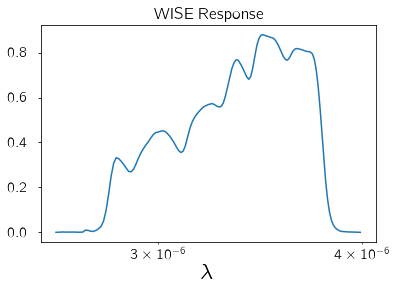

In [66]:
import speclite
from speclite import filters
#boo = speclite.filters
wise = speclite.filters.load_filters('wise2010-*')
print(wise.names)
w1band = speclite.filters.load_filter('wise2010-W1')
w2band = speclite.filters.load_filter('wise2010-W2')
w3band = speclite.filters.load_filter('wise2010-W3')
w4band = speclite.filters.load_filter('wise2010-W4')
wave_w1 = (w1band.wavelength)*(10**(-10))
resp = w1band.response
#print(w1)
# print(rband(6220))
eff = w1band.effective_wavelength.value
print(eff)

plt.plot(wave_w1,resp)
plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.title('WISE Response')
plt.show()


# wise = speclite.filters.load_filters('wise2010-*')
# speclite.filters.plot_filters(wise, wavelength_limits=(2, 30),
#     wavelength_unit=astropy.units.micron, wavelength_scale='log')
# plt.gca().set_xticks([2, 5, 10, 20, 30])
# plt.gca().set_xticklabels([2, 5, 10, 20, 30])

In [7]:
os.chdir('/Users/nitya/Work/Data/Project1/measurements')
print(os.getcwd())


afile = open(r'interpolated_data.pkl', 'rb')
dat = pickle.load(afile, encoding = 'latin1')
afile.close()




/Users/nitya/Work/Data/Project1/measurements


#Writing out this integral: K = -2.5log10((1/(1+z))(I1/I2))
I1, I2 are convolutions with functions/arrays f1,f2 for specified filters;
f1: w*L(w/1+z)
f2: w*L(w

In [57]:
t = binned_statistic_2d(dat['inf'],dat['opt'],dat['nsaid'],statistic = 'count',bins = (25,25))

bl = t[3]
print(len(bl))


def f1(lam):
    x = lam/(1+z)
    fc = np.interp(x, 10**wav, us1)
    thing = lam*(10**fc)
    return thing

def f2(lam):
    fc = np.interp(lam, 10**wav, us1)
    thing = lam*(10**fc)
    return thing


  

61046


In [34]:
os.chdir('/Users/nitya/Work/Data/Project1/magphys')

b = np.unique(bl)

ble = np.vectorize(np.float)
sed = []

for i in range(len(b)):
    ind = np.int(b[i])
    f = str(bl[i]) + '.0' + '.sed'
    lines2 = open(f).readlines()[10:]
    se = np.asarray([ble(lines2[j].split()) for j in range(12816)])
    sed.append(se)
    



In [42]:
sed = np.asarray(sed)
print(len(sed))
print(np.shape(sed))
print(sed[10][:,0][0:10])
print(b)

444
(444, 12816, 3)
[1.959041 1.973128 1.982271 1.991226 2.       2.0086   2.017033 2.025306
 2.033424 2.041393]
[ 45  49  71  72  73  74  77  89  91  92  93  95  98  99 100 101 102 103
 104 105 116 124 125 126 127 128 129 130 131 132 133 136 143 144 145 149
 151 152 153 154 155 156 157 158 159 160 168 170 171 175 176 177 178 179
 180 181 182 183 184 185 186 187 195 199 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 222 223 224 225 226 227 229 230 231 232 233 234
 235 236 237 238 239 240 241 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 266 267 268 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 303 304 305 306 307 308 309 310 311 312
 313 314 315 316 317 318 319 320 321 322 330 331 332 333 334 335 336 337
 338 339 340 341 342 343 344 345 346 347 348 349 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 382
 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400
 401 402 40

In [ ]:
#Reading the Magphys spectra..;
#os.chdir('/Users/nitya/Work/Data/Project1/Magphys')

#print(b)
# print(bl[i])


kc1 = []
kc2 = []
kc3 = []
kc4 = []
for i in range(len(bl)):
#     ind = np.int(bl[i])
#     file2 = str(bl[i]) + '.0' + '.sed'
#     lines2 = open(file2).readlines()[10:]
#     #print(np.shape(lines2))
#     ble = np.vectorize(np.float)
#     sed = np.asarray([ble(lines2[j].split()) for j in range(12816)])
    z = dat['z'][i]
    ind = np.where(b==bl[i])[0]
    
    #print(ind)
    l = np.reshape(sed[ind],(12816,3))
    #print(l[0:10])
    wav = l[:,0]
    #wav = [10**(sed[ind][:,0][j]) for j in range(len(sed[ind][:,0]))]
    #print(wav[0:20])
    #unattennuated
    #us = sed[inn][:,2]
    #attennuated
    #wav = [10**(sed[ind][:,0][j]) for j in range(len(sed[ind][:,0]))]
    us1 = l[:,1]
    #print(us1[0:10])


    a1 = w1band.convolve_with_function(f1)
    c1 = w1band.convolve_with_function(f2)
    kcorr1 = np.float(-2.5*(np.log10(a1/c1)))
    kc1.append(kcorr1)

    a2 = w2band.convolve_with_function(f1)
    c2 = w2band.convolve_with_function(f2)
    kcorr2 = np.float(-2.5*(np.log10(a2/c2)))
    kc2.append(kcorr2)

    a3 = w3band.convolve_with_function(f1)
    c3 = w3band.convolve_with_function(f2)
    kcorr3 = np.float(-2.5*(np.log10(a3/c3)))
    kc3.append(kcorr)

    a4 = w4band.convolve_with_function(f1)
    c4 = w4band.convolve_with_function(f2)
    kcorr4 = np.float(-2.5*(np.log10(a4/c4)))
    kc4.append(kcorr4)
    

print(kc1[0:5])
print(kc2[0:5])
print(kc3[0:5])
print(kc4[0:5])

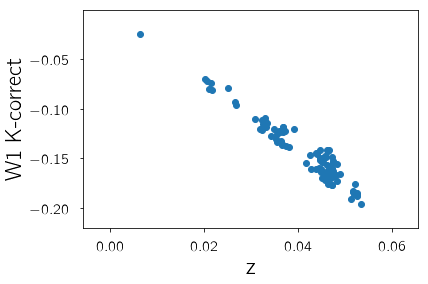

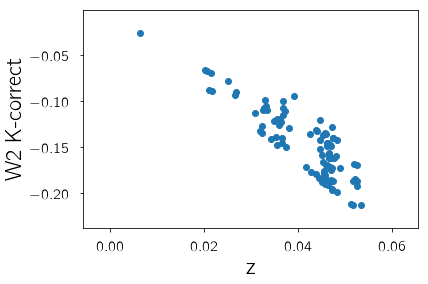

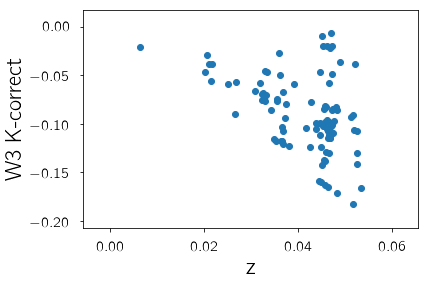

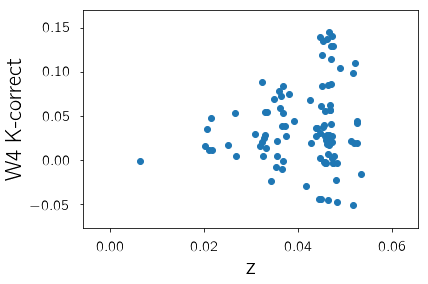

In [68]:
plt.scatter(dat['z'][0:100],kc1)
plt.xlabel('z')
plt.ylabel('W1 K-correct')
plt.show()


plt.scatter(dat['z'][0:100],kc2)
plt.xlabel('z')
plt.ylabel('W2 K-correct')
plt.show()

plt.scatter(dat['z'][0:100],kc3)
plt.xlabel('z')
plt.ylabel('W3 K-correct')
plt.show()

plt.scatter(dat['z'][0:100],kc4)
plt.xlabel('z')
plt.ylabel('W4 K-correct')
plt.show()

In [ ]:

# one = ap.units.Quantity(1.)
# numer = w1band.convolve_with_function(lambda wlen: wlen)
# denom = w1band.convolve_with_function(lambda wlen: one)
# print(numer)
# print(denom)
# print(np.round(numer / denom, 1))

# z = 0.05491536


# ##Testing functions: Can you get back the effective wavelength?
# def test1(lam):
#     blah = lam
#     return blah

# def test2(lam):
#     blah = 1.0
#     return blah

# print(trial1)
# print(trial2)
# print(trial1/trial2)


# ## Defining 2 functions of wavelength...

# def f1(lam):
#     x = lam/(1+z)
#     fc = np.interp(x, 10**wav, us1)
#     thing = lam*(10**fc)
#     return thing

# def f2(lam):
#     fc = np.interp(lam, 10**wav, us1)
#     thing = lam*(10**fc)
#     return thing

# print(10**wav[0:10])
# print(us1[0:10])
# print(f2(93.5))

# trial1 = w1band.convolve_with_function(test1)
# trial2 = w1band.convolve_with_function(test2)


# a = w1band.convolve_with_function(f1)
# b = w1band.convolve_with_function(f2)

# print(a,b)

# kcorr = -2.5*(np.log10(a/b))
# print(kcorr)



# print(dat.dtype.names)
# print(len(dat))
# print(binlist[300])
# gal = np.random.choice(binlist[400])
# print(gal)
# #z = np.asarray([dat['z'][np.where(dat['nsaid'] == np.array(binlist[100][i]))[0]] for i in range(len(binlist[100]))])
# z = dat['z'][np.where(dat['nsaid']==gal)]
# print(z)



# #print(wave_w1)
# # wl = np.power(10,np.asarray(sed[1][:,0]))

# # #print(wl, len(wl), wl[6400:6700])


# # lum = []
# # #attennuated
# # alum = []

# # lum1 = []
# # #attennuated
# # alum1 = []

# for i in range(len(bins)):
#     wav = np.power(10,np.asarray(sed[i][:,0]))
#     us = np.power(10,np.asarray(sed[i][:,2]))
#     s = np.power(10,np.asarray(sed[i][:,1]))
#     print(len(wav),len(us),len(s))
    
# #     #print(np.any(np.diff(wl <= 0)))
# #     spec = [wl[j]*s[j] for j in range(len(wl))]
# #     uspec = [wl[j]*us[j] for j in range(len(wl))]
# #     #print(wl[6400:6700],s[6400:6700])
# #     stuff1 = w1band.convolve_with_array(wl[6400:6700],s[6400:6700],photon_weighted=False)
# #     ustuff1 = w1band.convolve_with_array(wl,us,photon_weighted=False)
# #     stuff = w1band.convolve_with_array(wl,spec,photon_weighted=False)
# #     ustuff = w1band.convolve_with_array(wl,uspec,photon_weighted=False)
# #     #print(stuff1,ustuff1,stuff,ustuff)
# #     #ab = w1band.get_ab_magnitude(s[0:6000])
# #     alum.append(stuff)
# #     lum.append(ustuff)
# #     #maggie.append(ab)
# #     alum1.append(stuff1)
# #     lum1.append(ustuff1)

